### QQQ stock prediction using RNN, LSTM, GRU

In [86]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATASET_PATH = './dataset/QQQ.csv'
assert os.path.exists(DATASET_PATH), 'Path to dataset does not exist'

In [3]:
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(1048, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,214.399994,216.160004,213.979996,216.160004,210.883881,30969400
1,2020-01-03,213.300003,215.470001,213.279999,214.179993,208.952179,27518900
2,2020-01-06,212.500000,215.589996,212.240005,215.559998,210.298523,21655300
3,2020-01-07,215.639999,216.139999,214.850006,215.529999,210.269226,22139300
4,2020-01-08,215.500000,218.139999,215.160004,217.149994,211.849686,26397300


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1.048000e+03
mean,319.103464,321.825277,316.258369,319.240229,315.282932,5.239064e+07
std,56.083078,55.877379,56.152535,56.068917,56.655009,2.277609e+07
min,170.919998,174.210007,164.929993,169.300003,165.167633,1.549880e+07
25%,281.977501,284.892502,279.737504,282.674996,278.984100,3.645432e+07
50%,318.804993,322.544998,315.994995,319.100006,316.004242,4.844750e+07
75%,364.644989,366.820000,361.794991,364.457497,360.579292,6.319948e+07
max,439.899994,446.579987,439.839996,445.609985,445.609985,1.986858e+08


In [5]:
# df['Timestamp'] = pd.to_datetime(df['Date']).astype('int64') / 10**9

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

<Axes: ylabel='Close'>

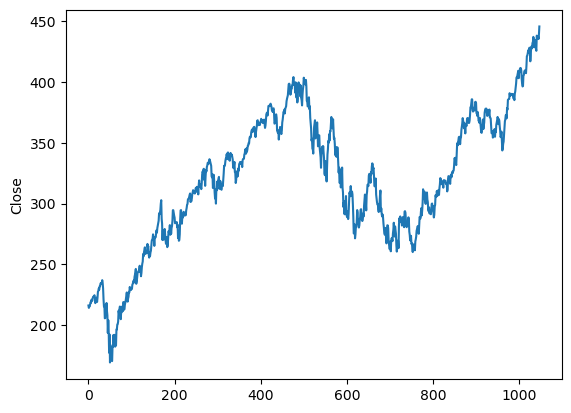

In [6]:
sns.lineplot(df, y = 'Close', x = df.index)

### Prep train and test data

In [20]:
train_df = df.drop("Date", axis = 1)
train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())

train_size = 0.8
test_size = (1.0 - 0.8) / 2
train_df.reset_index(inplace = True)

# x_train, x_val_test, y_train, y_val_test = train_test_split(train_df, train_size=train_size)
# x_val, x_test, y_val, y_test = train_test_split((x_val_test, y_val_test), test_size=test_size)

train_df.describe()


,index,Open,High,Low,Close,Adj Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,523.500000,0.550909,0.541966,0.550465,0.542652,0.535280,0.201389
std,302.675844,0.208503,0.205152,0.204258,0.202920,0.202020,0.124332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,261.750000,0.412884,0.406368,0.417619,0.410318,0.405846,0.114394
50%,523.500000,0.549799,0.544608,0.549507,0.542145,0.537852,0.179864
75%,785.250000,0.720221,0.707163,0.716107,0.706299,0.696798,0.260393
max,1047.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
def prep_series_dataset(df, target, timestep):
    X = []
    y = []
    N = len(df)
    features = np.array(df)
    labels = np.array(df[target])
    if timestep >= N: return features[:-1], labels[-1]

    for i in range(len(df) - timestep):
        X.append(features[i: i + timestep])
        y.append(labels[i + timestep])
    return np.array(X), np.array(y)

#quick test
X,y = prep_series_dataset(df[:10], 'Close', 5)
print(X.shape)
print(y.shape)

(5, 5, 7)
(5,)


In [32]:
print(train_df.shape)

(1048, 7)


In [125]:
timestep = 10

X, y = prep_series_dataset(train_df, 'Close', timestep)
X = torch.tensor(X)
y = torch.tensor(y)
print(X.shape, ' dtype = ', X.dtype)
print(y.shape, ' dtype = ', y.dtype) 

torch.Size([1038, 10, 7])  dtype =  torch.float64
torch.Size([1038])  dtype =  torch.float64


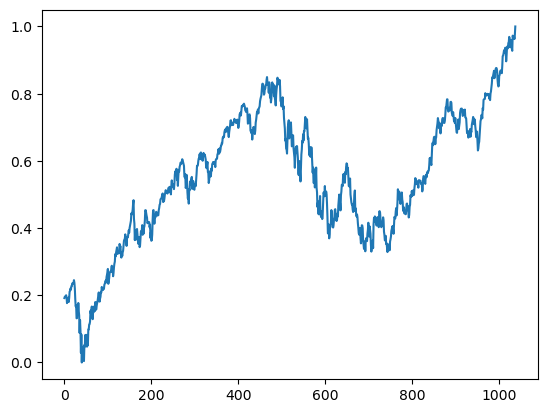

In [151]:
sns.lineplot(y = y, x = list(range(len(y))))
plt.show()

In [152]:
train_size = 0.8
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, train_size = train_size, shuffle = False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, shuffle = False)

print("X train shape = ", x_train.shape)
print("y train shape = ", y_train.shape)
print("X val shape = ", x_val.shape)
print("y val shape = ", y_val.shape)
print("X test shape = ", x_test.shape)
print("y test shape = ", y_test.shape)

X train shape =  torch.Size([830, 10, 7])
y train shape =  torch.Size([830])
X val shape =  torch.Size([104, 10, 7])
y val shape =  torch.Size([104])
X test shape =  torch.Size([104, 10, 7])
y test shape =  torch.Size([104])


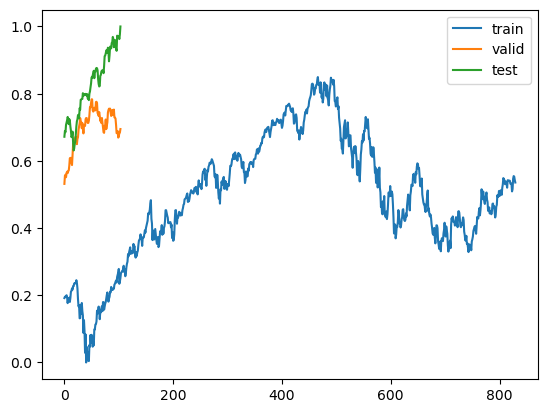

In [147]:
sns.lineplot(y = y_train, x = list(range(len(y_train))), label = 'train')
sns.lineplot(y = y_val, x = list(range(len(y_val))), label = 'valid')
sns.lineplot(y = y_test, x = list(range(len(y_test))), label = 'test')
plt.show()

### Build model

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
loss = 0.0739343979636074 score = 0.07393439796360742: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


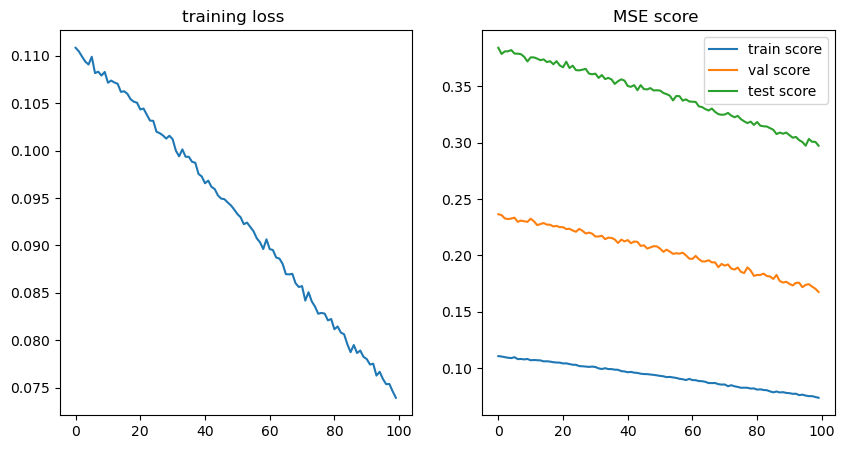

In [148]:
samples, numstep, input_size  = x_train.shape
hidden_size = 10 

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.5):
        super().__init__()
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers = num_layers, 
        # dropout = dropout, dtype=torch.float64)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, 
        dropout = dropout, dtype=torch.float64)
        self.dense = nn.LazyLinear(1, dtype = torch.float64)
    
    def forward(self, X):
        outputs, state = self.rnn(X)
        return self.dense(outputs), state

#quick test of simple RNN
rnn = SimpleRNN(input_size, hidden_size, num_layers = 5)
outputs, state = rnn(x_train) 

optim = torch.optim.Adam(rnn.parameters(), lr = 0.0001)
loss = nn.MSELoss()

#train for 10 epochs
epochs = 100
loop = tqdm(range(epochs))
history = []

best_score = 0 

for e in loop:
    outputs, state = rnn(x_train)
    y_pred = outputs[:, -1].squeeze(-1)

    l = loss(y_pred, y_train)
    l.backward()
    optim.step()

    #evaluate score
    score = mean_squared_error(y_train, y_pred.detach().numpy())
    loop.set_description(f'loss = {l.item()} score = {score}')

    val_output, state_val = rnn(x_val)
    y_pred_val = val_output[:, -1].squeeze(-1)
    val_score = mean_squared_error(y_val, y_pred_val.detach().numpy())

    test_output, state_val = rnn(x_test)
    y_pred_test = test_output[:, -1].squeeze(-1)
    test_score = mean_squared_error(y_test, y_pred_test.detach().numpy())

    history.append({
        'loss': l.item(),
        'train_score': score,
        'val_score': val_score,
        'test_score': test_score,
    })

    if best_score < test_score:
        best_score = test_score
        torch.save(rnn, 'rnn.checkpoint.torch')

loss_arrays = [h['loss'] for h in history]
train_score_arrays = [h['train_score'] for h in history]
val_score_arrays = [h['val_score'] for h in history]
test_score_arrays = [h['test_score'] for h in history]
index = list(range(len(history)))


fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
sns.lineplot(y = loss_arrays, x = list(range(len(loss_arrays))), ax = ax1)
ax1.set_title("training loss ")
sns.lineplot(y = train_score_arrays, x = index, ax = ax2, label = 'train score') 
sns.lineplot(y = val_score_arrays, x = index, ax = ax2, label = 'val score') 
sns.lineplot(y = test_score_arrays, x = index, ax = ax2, label = 'test score') 
ax2.set_title("MSE score ")

plt.show()

In [153]:
# model = torch.load('rnn.checkpoint.torch')
model = SimpleRNN(input_size, hidden_size, num_layers = 5)

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


y_pred shape = (1038,)
y truth shape = torch.Size([1038])


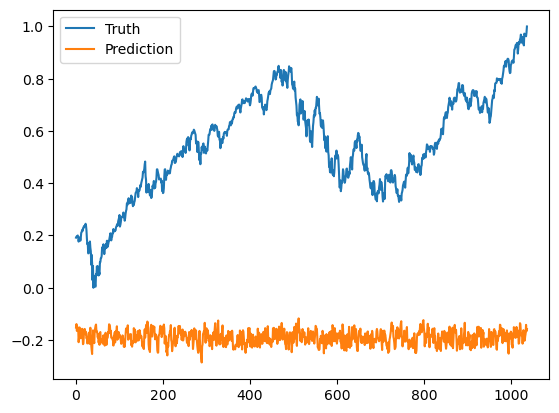

In [154]:
#predict on test data
# y = np.array(train_df['Close'])
outputs, state = model(X)
y_pred = outputs[:,-1].squeeze(-1).detach().numpy()

print('y_pred shape =', y_pred.shape)
print('y truth shape =', y.shape)

sns.lineplot(y = y,x = list(range(len(y))), label = 'Truth')
sns.lineplot(y = y_pred, x = list(range(len(y_pred))), label = 'Prediction')
plt.show()